Predictions before Training:

	$35336.40
	$35492.31
	$35415.17
	$35311.00
	$35493.51
	$35423.28
	$35558.41
	$35511.29
	$35382.53
	$35513.35
	.........
	.........


Epoch: 0
	Average training cost: 65131.33
	Average validation cost: 91558.28
Epoch: 500
	Average training cost: 62836.11
	Average validation cost: 88445.32
Epoch: 1000
	Average training cost: 60776.25
	Average validation cost: 85575.75
Epoch: 1500
	Average training cost: 58814.18
	Average validation cost: 82940.87
Epoch: 2000
	Average training cost: 57227.04
	Average validation cost: 80519.58
Epoch: 2500
	Average training cost: 55621.30
	Average validation cost: 78292.91
Epoch: 3000
	Average training cost: 54197.79
	Average validation cost: 76246.56
Epoch: 3500
	Average training cost: 53082.70
	Average validation cost: 74361.54
Epoch: 4000
	Average training cost: 51875.16
	Average validation cost: 72625.47
Epoch: 4500
	Average training cost: 50729.77
	Average validation cost: 71026.08
Avg Cost:

	[65131.33097805]
	[64879.126

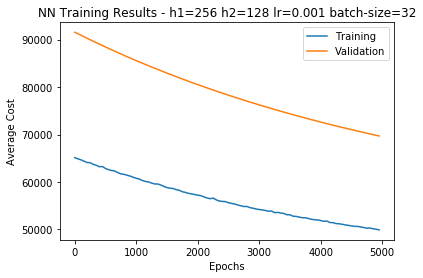

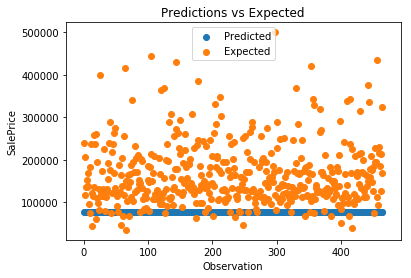

In [6]:
import pandas as pd
import numpy as np
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from dataPrep import prepare_data
from neuralNetwork import Neural_Net as neuralNetwork

'''
Wrapper to run the network and get user-defined parameters
'''
class run_network(object):

    '''
    Gets parameters from user
    * NOTICE * no input validation
    '''
    def __init__(self):
        self.h1_size = int(input("How many nodes in 1st hidden layer?\n"))
        self.h2_size = int(input("How many nodes in 2nd hidden layer?\n"))
        self.lrate = float(input("What should the learning rate be? (0 for default)\n"))
        self.batch_size = int(input("What should the batch-size be? (0 for default)\n"))
        self.num_epoch = int(input("How many epochs to train?\n"))

    '''
    Prepares the housing data in 1 function using the dataPrep file
    '''
    def prep_data(self):
        random.seed(10)
        df = pd.read_csv('otherhousing.csv')
        self.x_scaler = preprocessing.MinMaxScaler()
        self.y_scaler = preprocessing.MinMaxScaler()

        prep = prepare_data(self.x_scaler, self.y_scaler)
        clean_df = prep.pre_process(df)
        new_df = pd.read_csv('otherhousing_test.csv')
        new_clean_df = prep.pre_process(new_df)
        self.test_df_order = new_clean_df['Order']
        new_clean_df = new_clean_df.drop(['Order'], axis=1)
        target = clean_df['SalePrice']

        for i in clean_df.columns:
            if i not in new_clean_df.columns:
                clean_df = clean_df.drop([i], axis=1)

        for i in new_clean_df.columns:
            if i not in clean_df.columns:
                new_clean_df = new_clean_df.drop([i], axis=1)

        features = clean_df

        test_df = self.x_scaler.fit_transform(new_clean_df)
        test_df = pd.DataFrame(test_df)
        self.test_df = test_df

        self.x_train, self.x_test, self.x_val, self.y_train, self.y_test, self.y_val = prep.split_norm(features, target)

    '''
    Creates the neural network object
    '''
    def initalize(self):
        if self.lrate != 0:
            self.nn = neuralNetwork(self.x_train.shape[1], self.h1_size, self.h2_size, lr = self.lrate)
        else:
            self.nn = neuralNetwork(self.x_train.shape[1], self.h1_size, self.h2_size)

    '''
    Trains the network
    '''
    def train_network(self):
        # create lists for cost output
        self.epoch_list = []
        self.train_cost_list = []
        self.val_cost_list = []

        # define steps for adding to lists and printing progress
        small_step = int(self.num_epoch / 100)
        large_step = int(self.num_epoch / 10)
        
        # cycle through epochs
        for epoch in range(self.num_epoch):
            # shuffle x and y data
            random_idx = np.random.choice(len(self.y_train), len(self.y_train), replace=False)
            x_shuffled = self.x_train.values[random_idx,:]
            y_shuffled = self.y_train.values[random_idx]

            # run 1 training step
            if self.batch_size != 0:
                avg_batch_cost = self.nn.train_step(x_shuffled, y_shuffled, batch_size = self.batch_size)
            elif self.batch_size == 0:
                avg_batch_cost = self.nn.train_step(x_shuffled, y_shuffled)

            # add cost values to list
            if epoch % small_step == 0:
                self.train_cost_list.append(avg_batch_cost)
                self.epoch_list.append(epoch)
                
                val_pred = self.nn.forward(self.x_val)
                val_cost = self.nn.get_cost(len(self.y_val), self.y_val, val_pred)
                self.val_cost_list.append(val_cost)

            # print progress every-so often
            if epoch % large_step == 0:
                train_cost_norm = self.y_scaler.inverse_transform(np.asarray(avg_batch_cost).reshape(1, -1))
                val_cost_norm = self.y_scaler.inverse_transform(np.asarray(val_cost).reshape(1, -1))
                print('Epoch: %d' % (epoch))
                print("\tAverage training cost: %.2f" % (train_cost_norm))
                print("\tAverage validation cost: %.2f" % (val_cost_norm))

    '''
    Prints predictions before training
    *NOTICE* these will be very strange predictions
    '''
    def print_results_before(self):

        print("Predictions before Training:\n")
        before = self.nn.forward(self.x_train.values)
        before = self.y_scaler.inverse_transform(np.asarray(before))

        for i in range(10):
            print("\t$%.2f" % (before[i]))
        print("\t.........")
        print("\t.........")
        print("\n")
    
    '''
    Prints part of our training cost during training
    '''
    def print_training_results(self):

        avg_cost_list = self.y_scaler.inverse_transform(np.asarray(self.train_cost_list).reshape(-1, 1))

        print("Avg Cost:\n")
        for i in range(10):
            print("\t" + str(avg_cost_list[i]))
            
        print("\t.........")
        print("\t.........")
        print("\n")

    '''
    Prints predictions on training data after training
    '''
    def print_results_after(self):

        print("After Training:\n")
        preds = self.nn.forward(self.x_train.values)
        preds = self.y_scaler.inverse_transform(np.asarray(preds))

        for i in range(10):
            print("\t$%.2f" % (preds[i]))
        print("\t.........")
        print("\t.........")

    '''
    Plots our training and validation descent
    '''
    def plot_training_results(self):
        avg_cost_list = self.y_scaler.inverse_transform(np.asarray(self.train_cost_list).reshape(-1, 1))
        val_cost_list = self.y_scaler.inverse_transform(np.asarray(self.val_cost_list).reshape(-1, 1))

        plt.plot(self.epoch_list, avg_cost_list, label = "Training")
        plt.plot(self.epoch_list, val_cost_list, label = "Validation")
        plt.xlabel('Epochs')
        plt.ylabel('Average Cost')
        plt.title('NN Training Results - h1=' + str(self.h1_size) +" h2=" + str(self.h2_size) + " lr=" + str(self.lrate) + " batch-size=" + str(self.batch_size))
        plt.legend()
        return plt.show()

    '''
    Prints our predictions on our testing data vs expected
    '''
    def print_test_results(self):
        test_pred = self.nn.forward(self.x_test.values)
        test_pred = self.y_scaler.inverse_transform(np.asarray(test_pred))
        y_test_norm = self.y_scaler.inverse_transform(self.y_test.values)

        print("Predictions for test data:\n")

        for i in range(10):
            print('\tPredicted $%.2f; Expected: $%.2f' % (test_pred[i], y_test_norm[i]))
        print("\t..........................................")
        print("\t..........................................")

    '''
    Plots our testing predictions vs expected
    '''
    def plot_test_results(self):
        test_pred = self.nn.forward(self.x_test.values)
        test_pred = self.y_scaler.inverse_transform(np.asarray(test_pred))
        y_test_norm = self.y_scaler.inverse_transform(self.y_test.values)
        obs = range(0, self.x_test.shape[0])

        plt.scatter(obs, test_pred, label = "Predicted")
        plt.scatter(obs, y_test_norm, label = "Expected")
        plt.xlabel('Observation')
        plt.ylabel('SalePrice')
        plt.title('Predictions vs Expected')
        plt.legend()
        return plt.show()

    def new_test_results(self):
        test_predictions = self.nn.forward(self.test_df)
        test_predictions = self.y_scaler.inverse_transform(test_predictions)

        print("HIDDEN TEST SET PREDICTIONS:\n")
        for i in range(20):
            print("\t$%.2f" % (test_predictions[i]))

        # WRITE PREDICTIONS TO CSV
        predictions_df = pd.DataFrame(test_predictions)
        predictions_df.insert(0, 'Order', self.test_df_order)
        predictions_df.columns = ['Order','Prediction']

        predictions_df.to_csv('hidden_predictions_GSMITH.csv', index=False)

'''
Calls everything we need
'''
def main():
    network = run_network()
    network.prep_data()
    network.initalize()
    network.print_results_before()
    network.train_network()
    network.print_training_results()
    network.print_results_after()
    network.print_test_results()
    network.new_test_results()
    network.plot_training_results()
    network.plot_test_results()
    
'''
Run this already!
'''
if __name__ == '__main__':
    main()
    